In [100]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

import cvxpy as cp

In [4]:
data = pd.read_csv('../data/Stock_Bond_2004_to_2006.csv', index_col=1, parse_dates=[1])
data.head()

,Date,Three_month_treasury,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,...,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield,$/Euro,Yen/$,Brazil Real/$
DATE,,,,,,,,,,,,,,,,,,,,,
2004-01-02,2-Jan-04,0.91,4660000,46.72,9030400,14.55,3227600,45.13,4172800,39.35,...,1153200000,1.31,2.47,4.38,NaN,5.73,6.70,1.2592,106.95,2.8840
2004-01-05,5-Jan-04,0.90,7324400,47.55,20069800,15.02,3031000,45.40,6184200,40.42,...,1578200064,1.35,2.51,4.41,NaN,5.70,6.68,1.2679,106.10,2.8580
2004-01-06,6-Jan-04,0.90,4793800,47.26,16760800,14.97,3754200,45.29,6190400,39.70,...,1494499968,1.30,2.38,4.29,NaN,5.63,6.61,1.2773,106.20,2.8575
2004-01-07,7-Jan-04,0.89,8304600,47.91,13801900,15.38,3413200,45.43,6203200,39.27,...,1704899968,1.29,2.36,4.27,NaN,5.61,6.57,1.2665,106.19,2.8690
2004-01-08,8-Jan-04,0.86,8282800,47.90,15805300,15.48,3793200,45.38,4844400,38.97,...,1868400000,1.29,2.37,4.27,NaN,5.63,6.53,1.2772,106.17,2.8500


In [11]:
prices = data[['GM_AC', 'F_AC', 'UTX_AC', 'CAT_AC', 'MRK_AC', 'PFE_AC', 'IBM_AC', 'SP_AC']]
n = prices.shape[0]

In [69]:
stocks = ['GM_AC', 'F_AC', 'UTX_AC', 'CAT_AC', 'MRK_AC', 'PFE_AC', 'IBM_AC']

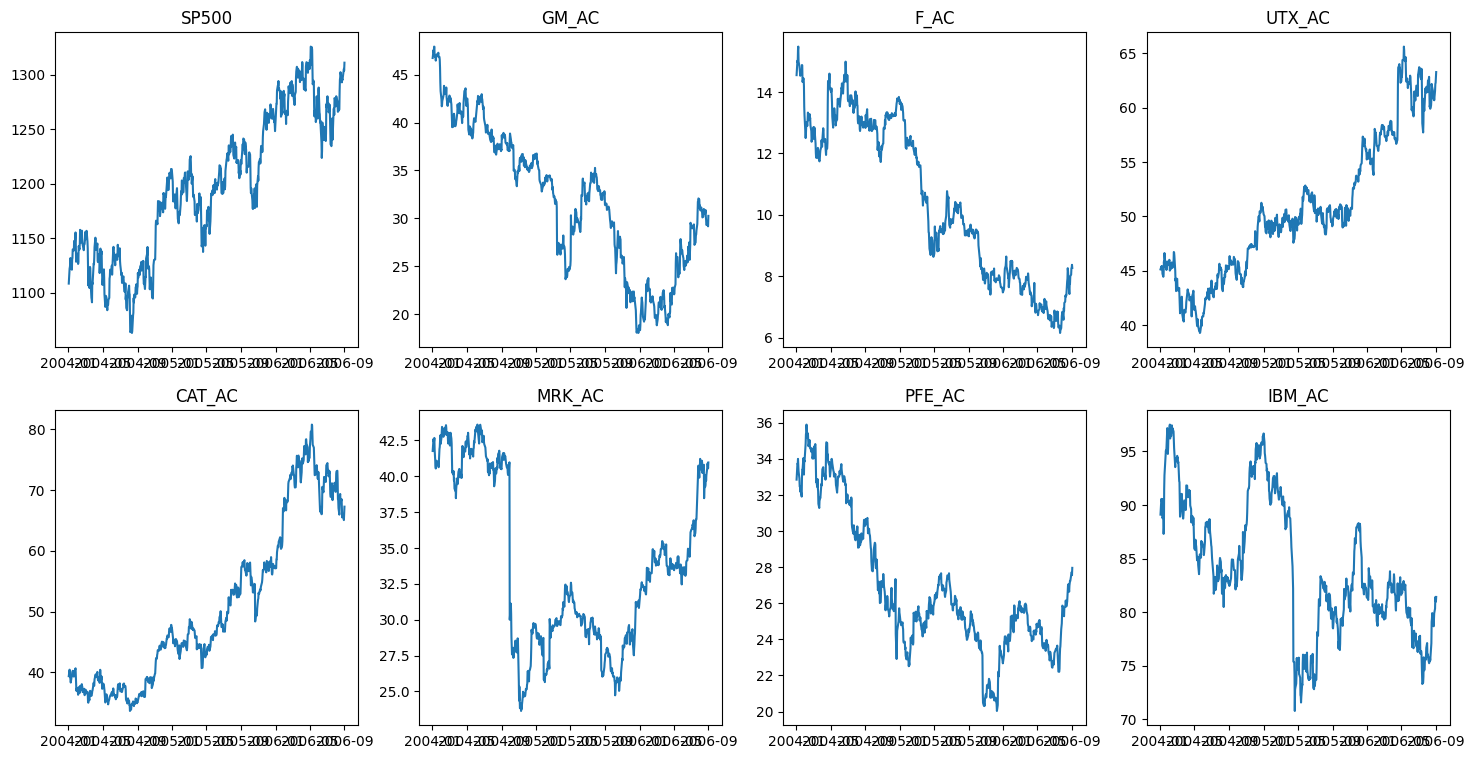

In [73]:
fig, axs = plt.subplots(2, 4, figsize=(18, 9))
axs[0][0].plot(prices['SP_AC']);
axs[0][0].set_title('SP500');
for i, stock in enumerate(stocks, 1):
    axs[i // 4][i % 4].plot(prices[stock]);
    axs[i // 4][i % 4].set_title(stock);

In [38]:
rf = data['Three_month_treasury'] / 365 / 100
ex_ret = prices.pct_change().subtract(rf, axis=0).dropna()

In [51]:
fits = []
for stock in stocks:
    fit = sm.OLS(ex_ret[stock], sm.add_constant(ex_ret['SP_AC'])).fit()
    fits.append(fit)

    print(f'{" " + stock + " ":*^78}')
    print()
    print(fit.summary())
    print()
    print()

*********************************** GM_AC ************************************

                            OLS Regression Results                            
Dep. Variable:                  GM_AC   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     92.15
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           1.56e-20
Time:                        14:06:35   Log-Likelihood:                 1611.4
No. Observations:                 672   AIC:                            -3219.
Df Residuals:                     670   BIC:                            -3210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

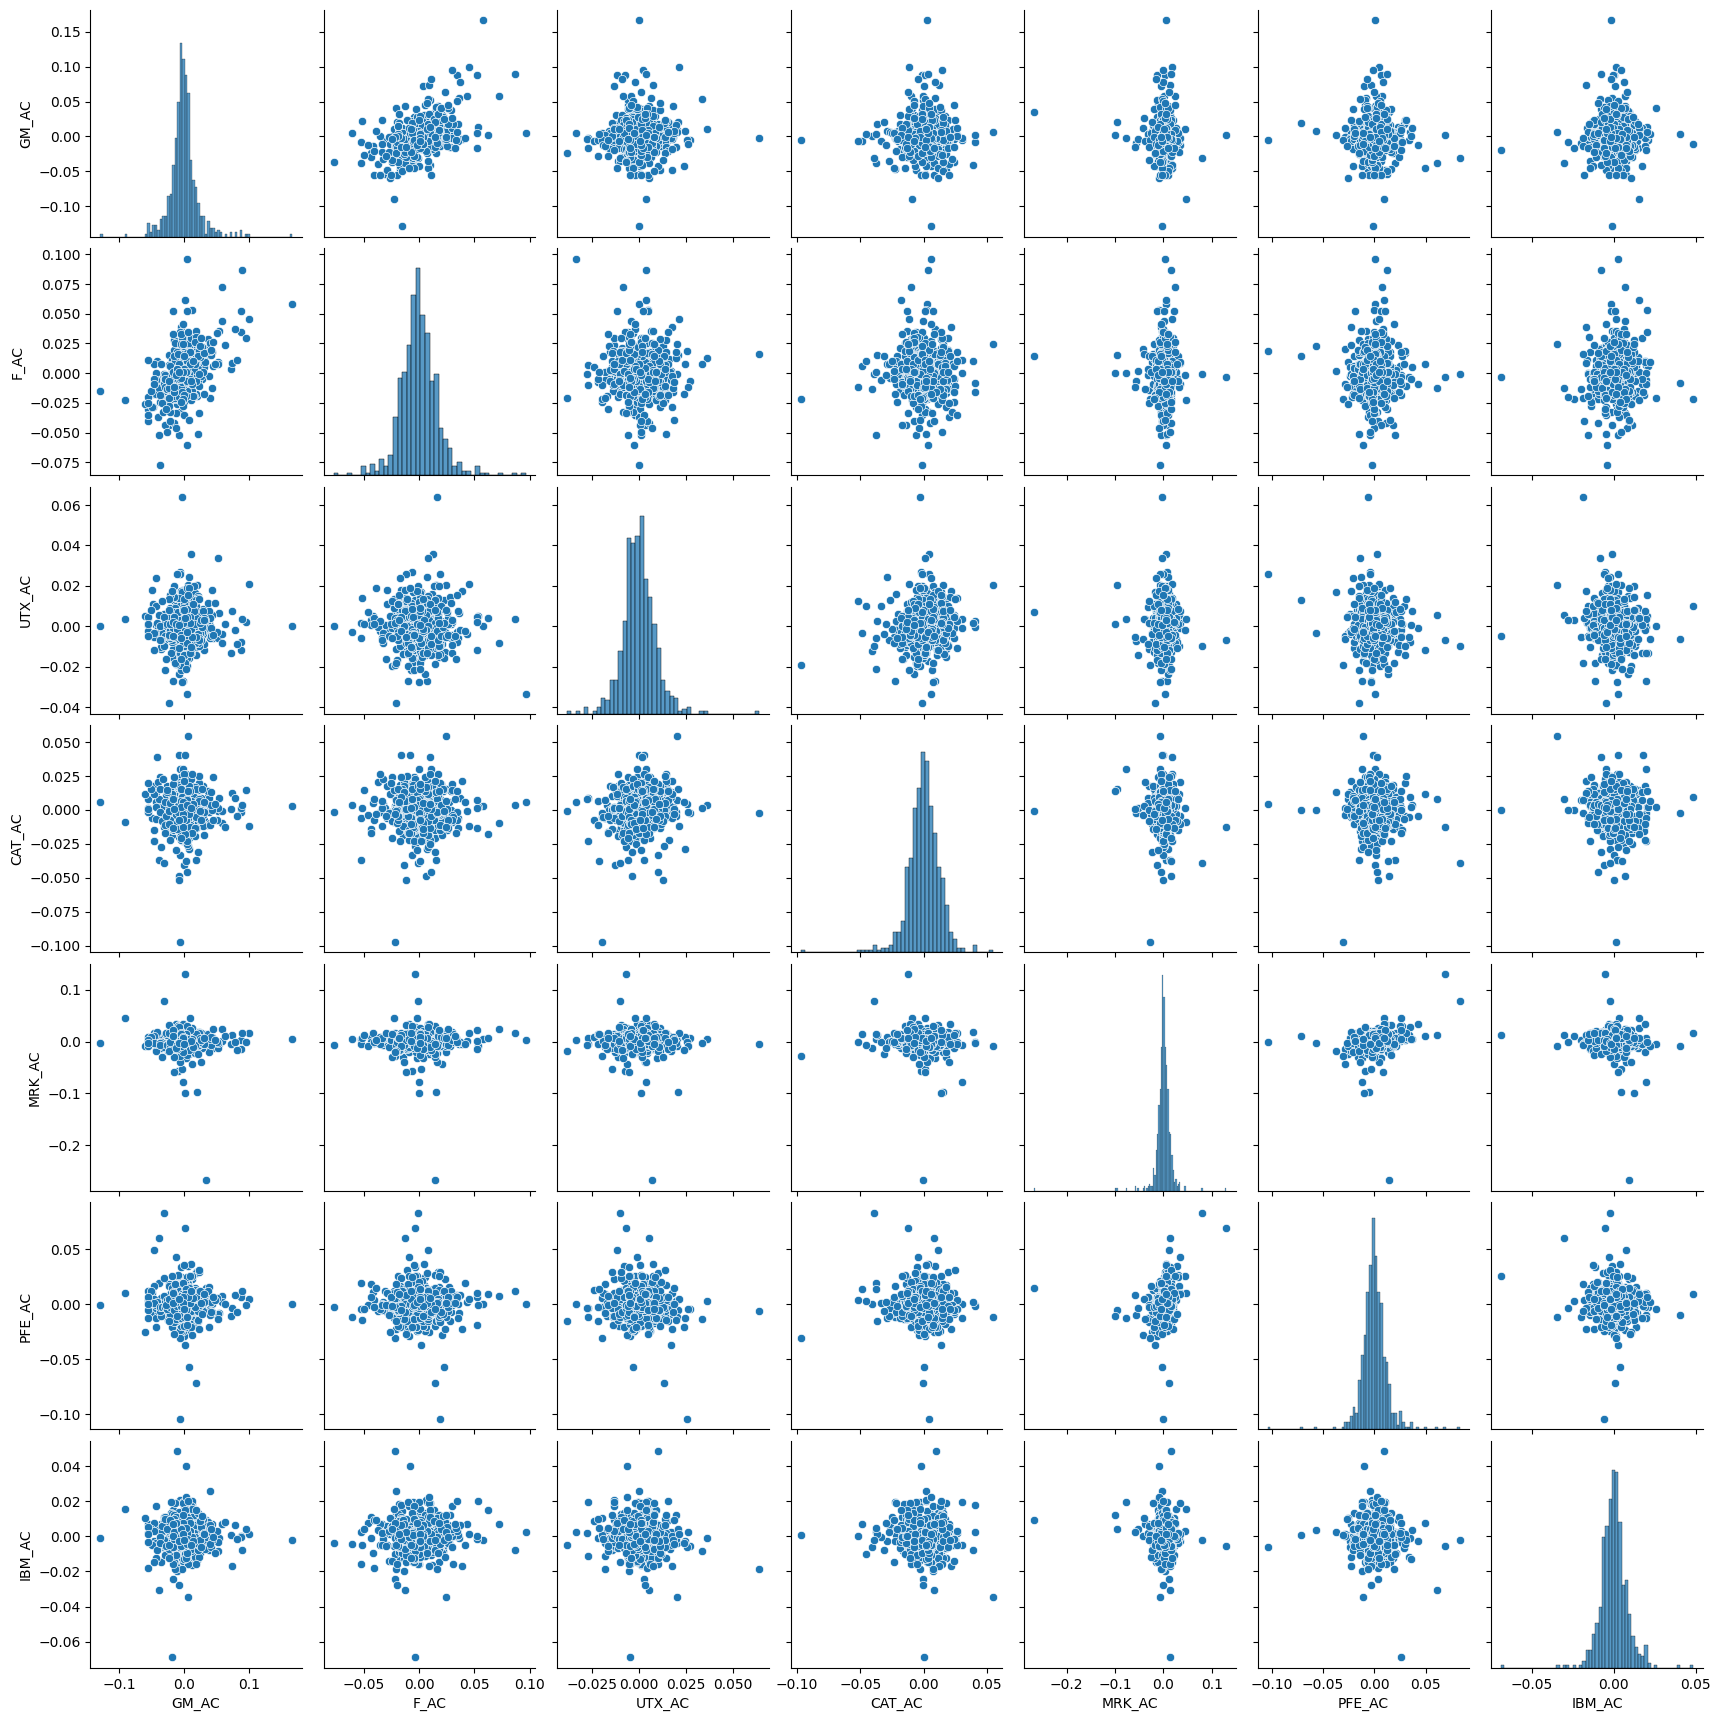

In [56]:
resid = pd.concat([fit.resid for fit in fits], axis=1)
resid.columns = stocks
sns.pairplot(resid);

In [62]:
betas = pd.Series([fit.params['SP_AC'] for fit in fits], index=stocks)
betas

GM_AC     1.202521
F_AC      1.237781
UTX_AC    0.976598
CAT_AC    1.409771
MRK_AC    0.749910
PFE_AC    0.949622
IBM_AC    0.821192
dtype: float64

#### Problem 1

The p-values of the intercept estimate are above 5% for all of the stocks, so we do not reject the null hypothesis that the intercept is zero in any of the cases.

#### Problem 2

In [68]:
ex_ret['SP_AC'].mean()

0.0001941221578769576

In [67]:
pd.DataFrame({
    'CAPM excess return': ex_ret['SP_AC'].mean() * betas,
    'Sample excess return': ex_ret[stocks].mean()
})

,CAPM excess return,Sample excess return
GM_AC,0.000233,-0.000452
F_AC,0.000240,-0.000736
UTX_AC,0.000190,0.000485
CAT_AC,0.000274,0.000842
MRK_AC,0.000146,0.000071
PFE_AC,0.000184,-0.000218
IBM_AC,0.000159,-0.000163


#### Problem 3

In [76]:
resid.corr()

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC,PFE_AC,IBM_AC
GM_AC,1.000000,0.509109,0.039669,0.020232,-0.047154,-0.018770,0.007849
F_AC,0.509109,1.000000,-0.007140,0.028947,0.012793,0.011422,0.035754
UTX_AC,0.039669,-0.007140,1.000000,0.149775,-0.015398,-0.111028,-0.069486
CAT_AC,0.020232,0.028947,0.149775,1.000000,-0.075725,-0.064962,-0.083423
MRK_AC,-0.047154,0.012793,-0.015398,-0.075725,1.000000,0.283274,-0.078170
PFE_AC,-0.018770,0.011422,-0.111028,-0.064962,0.283274,1.000000,-0.046057
IBM_AC,0.007849,0.035754,-0.069486,-0.083423,-0.078170,-0.046057,1.000000


The largest positive correlations are between F and GM (0.51), MRK and PFE (0.28), CAT and UTX (0.15). These are due to F and GM, MRK and PFE being in the same industries, and CAT and UTX being in related industries.

#### Problem 4

The estimate of the covariance matrix is:

In [88]:
betas.to_frame() @ betas.to_frame().T * ex_ret['SP_AC'].var(ddof=1) + np.diag(resid.var(ddof=1))

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC,PFE_AC,IBM_AC
GM_AC,0.000551,0.000069,0.000054,0.000078,0.000042,0.000053,0.000046
F_AC,0.000069,0.000367,0.000056,0.000080,0.000043,0.000054,0.000047
UTX_AC,0.000054,0.000056,0.000123,0.000063,0.000034,0.000043,0.000037
CAT_AC,0.000078,0.000080,0.000063,0.000244,0.000049,0.000062,0.000053
MRK_AC,0.000042,0.000043,0.000034,0.000049,0.000333,0.000033,0.000028
PFE_AC,0.000053,0.000054,0.000043,0.000062,0.000033,0.000200,0.000036
IBM_AC,0.000046,0.000047,0.000037,0.000053,0.000028,0.000036,0.000099


#### Problem 5

The proportion of excess return of UTX due to market is:

In [97]:
fits[stocks.index('UTX_AC')].rsquared

0.35744346565686713

#### Problem 6

In [1006]:
betas * 0.04

GM_AC     0.048101
F_AC      0.049511
UTX_AC    0.039064
CAT_AC    0.056391
MRK_AC    0.029996
PFE_AC    0.037985
IBM_AC    0.032848
dtype: float64

### 17.9.1 Zero-beta Portfolios

In [1007]:
data = pd.read_csv('../data/AlphaBeta.csv', index_col=0)
data.head()

,alpha,beta
1,0.035715,1.034740
2,-0.029454,0.737724
3,-0.022415,0.875070
4,-0.024730,0.841863
5,0.031029,0.894594


#### Problem 7

In [1008]:
alpha = data['alpha'].values
beta = data['beta'].values

In [1009]:
w = cp.Variable(data.shape[0])
constraints = [
    cp.sum(w) == 1, 
    -0.25 <= w, w <= 0.25, 
    w.T @ beta == 0,
]
prob = cp.Problem(cp.Maximize(w.T @ alpha), constraints)
prob.solve()

0.1294361038709017

The weights of the optimal portfolio are:

In [1010]:
w.value

array([-0.01382471,  0.25      , -0.25      , -0.25      ,  0.25      ,
        0.25      ,  0.25      ,  0.25      ,  0.25      , -0.25      ,
        0.25      , -0.25      , -0.25      ,  0.25      , -0.25      ,
       -0.25      , -0.25      ,  0.01382471, -0.25      , -0.25      ,
        0.25      ,  0.25      , -0.25      ,  0.25      , -0.25      ,
       -0.25      ,  0.25      ,  0.25      ,  0.25      , -0.25      ,
       -0.25      ,  0.25      ,  0.25      ,  0.25      , -0.25      ,
       -0.25      ,  0.25      ,  0.25      ,  0.25      , -0.25      ,
       -0.25      ,  0.25      ,  0.25      ,  0.25      , -0.25      ,
        0.25      , -0.25      , -0.25      ,  0.25      ,  0.25      ])

#### Problem 8

In [1031]:
# data1 = data.sample(frac=1)
# alpha = data1['alpha'].values
# beta = data1['beta'].values

In [1032]:
w_lb = -0.25
w_ub = 0.25

In [1033]:
n = 38

In [1034]:
w = cp.Variable(n)
constraints = [
    cp.sum(w) == 1, 
    w_lb <= w, w <= w_ub, 
    w.T @ beta[:n] == 0,
]
prob = cp.Problem(cp.Maximize(w.T @ alpha[:n]), constraints)
prob.solve()

0.035478731466458434

The problem becomes infeasible, so no solution is found.

Consider the constraint
$$\sum_{i=1}^N w_i \beta_i = 0.$$
Denote $\beta'_i = \beta_i - \bar{\beta}$, where $\bar{\beta} = \frac1N \sum_{i=1}^N \beta_i$.
Then
$$
\sum_{i=1}^N w_i \beta_i
= \sum_{i=1}^N w_i (\beta'_i + \bar{\beta})
= \sum_{i=1}^N w_i \beta'_i + \bar{\beta} \sum_{i=1}^N w_i
= \sum_{i=1}^N w_i \beta'_i + \bar{\beta}
\geq \bar{\beta} - \left|\sum_{i=1}^N w_i \beta'_i\right|
\geq \bar{\beta} - \sum_{i=1}^N |w_i \beta'_i|
\geq \bar{\beta} - \max(w_u, -w_l) \sum_{i=1}^N |\beta'_i|
$$
If 
$$\bar{\beta} - \max(w_u, -w_l) \sum_{i=1}^N |\beta'_i| > 0,$$
then
$$\sum_{i=1}^N w_i \beta_i > 0$$
and so the problem cannot be feasible.

In [1035]:
def feasible(n):
    mean = np.mean(beta[:n])
    beta_prime = beta[:n] - mean
    return mean - max(w_ub, -w_lb) * np.sum(np.abs(beta_prime)) <= 0

In [1036]:
r = list(range(25, 45))
pd.DataFrame([[feasible(i)] for i in r], index=r)

,0
25,False
26,False
27,False
28,False
29,False
30,False
31,False
32,False
33,False
34,False
